## Phase 1: Data Loading & Initial EDA

In [1]:
import sys
sys.path.append('../src')  # Add source directory to path

### loding Required Libraries

In [2]:
from data_loading.wesad_loader import WESADLoader
from data_loading.physionet_loader import PhysioNetLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Dataset Initialization

In [3]:
wesad_path = '../raw_data/WESAD'
physionet_path = '../raw_data/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data'

In [4]:
wesad_loader = WESADLoader(wesad_path)
physionet_loader = PhysioNetLoader(physionet_path)

### WESAD Dataset Exploration

In [5]:
import pickle
with open('../raw_data/WESAD/S2/S2.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')
print(data.keys())  # Should show dict keys

dict_keys(['signal', 'label', 'subject'])


In [6]:
# Modify the WESAD loading cell to handle validation warnings
try:
    wesad_subject = wesad_loader.load_subject(2)
except ValueError as e:
    print(f"Loading failed: {str(e)}")
    wesad_subject = None

if wesad_subject is not None:
    # Display basic information
    print(f"Loaded subject {wesad_subject['subject_id'].iloc[0]} from WESAD")
    print(f"  - Total samples: {len(wesad_subject)}")
    print(f"  - Sampling rate: {wesad_subject['sampling_rate'].iloc[0]} Hz")
else:
    print("Could not load WESAD subject data")


182736 ACC samples exceed 3.5g
Invalid labels detected: {4.0, 6.0, 7.0}


Loaded subject 2 from WESAD
  - Total samples: 182738
  - Sampling rate: 30 Hz


In [7]:
# In your notebook
print(f"WESAD data columns: {wesad_subject.columns}")
print(f"Subject ID: {wesad_subject['subject_id'].unique()}")
print(f"Label distribution:\n{wesad_subject['label'].value_counts()}")

WESAD data columns: Index(['bvp', 'acc_x', 'acc_y', 'acc_z', 'label', 'subject_id',
       'sampling_rate'],
      dtype='object')
Subject ID: [2]
Label distribution:
label
0.0    118719
1.0     24267
4.0     16291
2.0     13046
3.0      7679
6.0      1379
7.0      1357
Name: count, dtype: int64


In [8]:
# After loading
print(f"Resampled shapes:")
print(f"BVP: {len(wesad_subject['bvp'])}")
print(f"ACC: {len(wesad_subject['acc_x'])}")
print(f"Labels: {len(wesad_subject['label'])}")

Resampled shapes:
BVP: 182738
ACC: 182738
Labels: 182738


#### Signal Visualization

In [9]:
def plot_wesad_signals(df):
    fig, ax = plt.subplots(4, 1, figsize=(15, 10))
    
    # BVP Plot
    ax[0].plot(df['bvp'], color='tab:red')
    ax[0].set_title('BVP Signal')
    
    # ACC Plots
    for i, axis in enumerate(['x', 'y', 'z']):
        ax[i+1].plot(df[f'acc_{axis}'], color='tab:blue')
        ax[i+1].set_title(f'Acceleration {axis.upper()}')
    
    plt.tight_layout()
    return fig

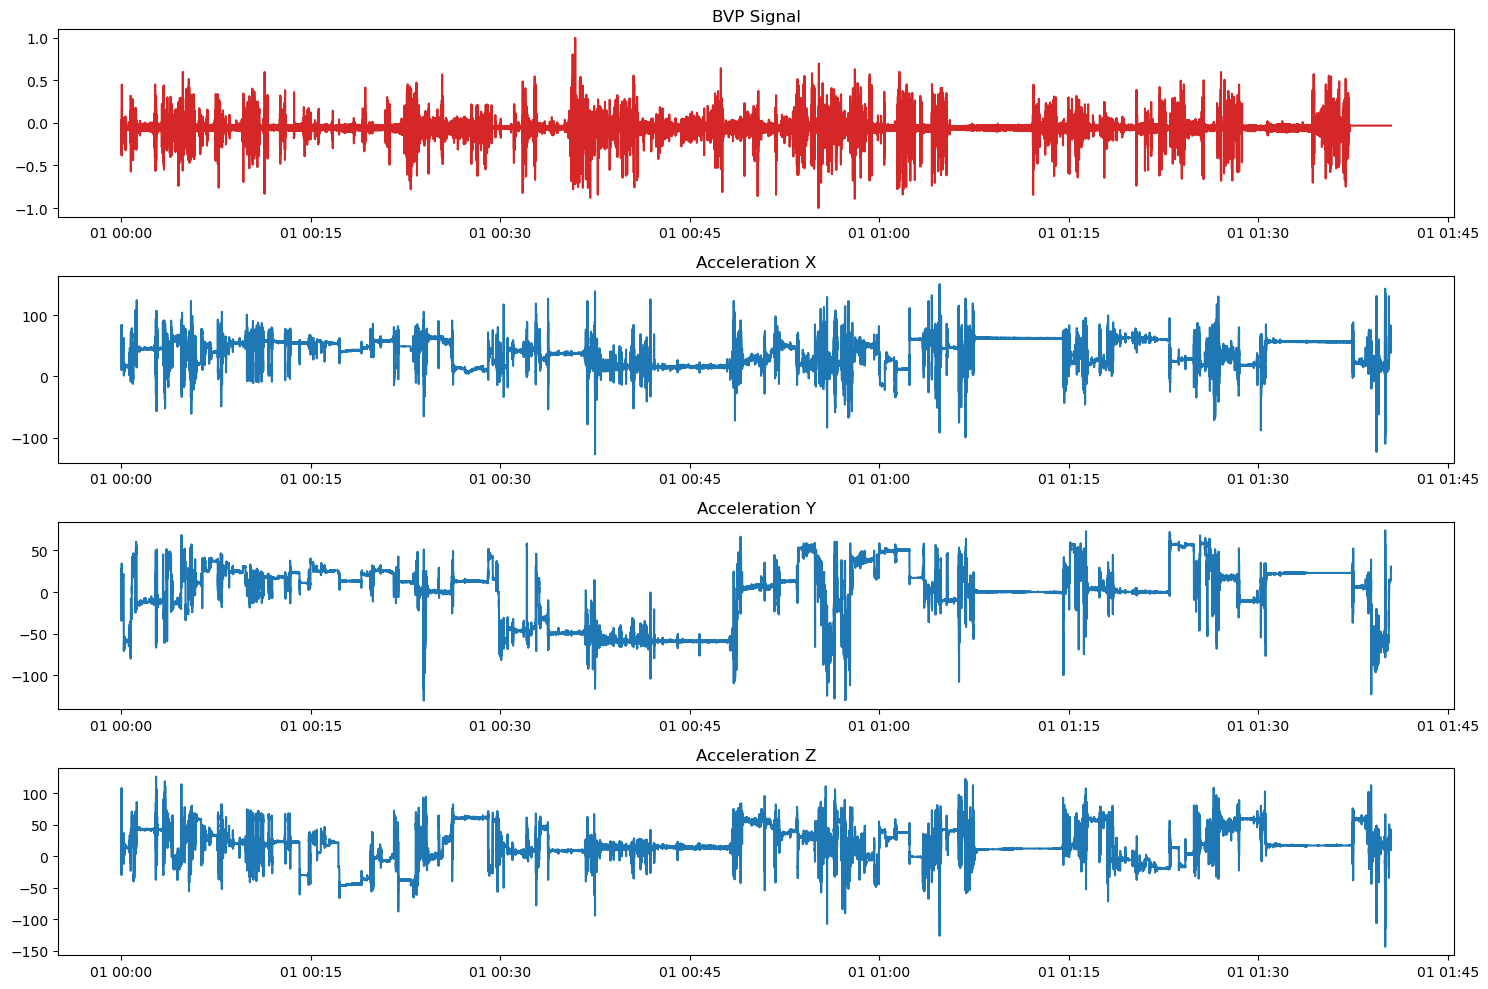

In [10]:
plot_wesad_signals(wesad_subject)
plt.show()

### PhysioNet Dataset Exploration

In [11]:
def debug_sensor(loader, sensor):
    path = loader.data_path/'S1'/'Midterm 1'/f"{sensor.upper()}.csv"
    print(f"\n{sensor.upper()} data:")
    print("Path exists:", path.exists())
    if path.exists():
        with open(path) as f:
            print("First 3 lines:", [next(f).strip() for _ in range(3)])
            
debug_sensor(physionet_loader, 'bvp')
debug_sensor(physionet_loader, 'acc')
debug_sensor(physionet_loader, 'hr')


BVP data:
Path exists: True
First 3 lines: ['1539435366.00', '64.000000', '-0.00']

ACC data:
Path exists: True
First 3 lines: ['1539435366.000000, 1539435366.000000, 1539435366.000000', '32.000000, 32.000000, 32.000000', '-3,-62,12']

HR data:
Path exists: True
First 3 lines: ['1539435376.000000', '1.000000', '84.00']


In [12]:
# Add quality assessment before loading
try:
    physionet_subject = physionet_loader.load_subject(1, 'Midterm 1')
except Exception as e:
    print(f"Critical error: {str(e)}")
    # Load ACC-only data for analysis
    acc_data = physionet_loader.load_acc_only(1, 'Midterm 1')
    if acc_data is not None:
        print(f"Loaded ACC data with {len(acc_data)} samples")

if physionet_subject is not None:
    print(f"Loaded subject {physionet_subject['subject_id']}")
    print(f"Samples: {len(physionet_subject)}")
    print(f"Columns: {physionet_subject.columns.tolist()}")
else:
    print("Failed to load PhysioNet data")

Tags processing failed: Both dates must have the same UTC offset


Loaded subject 2018-10-13 12:56:05.970000+00:00    1
2018-10-13 12:56:06.003000+00:00    1
2018-10-13 12:56:06.036000+00:00    1
2018-10-13 12:56:06.069000+00:00    1
2018-10-13 12:56:06.102000+00:00    1
                                   ..
2018-10-13 16:02:23.994000+00:00    1
2018-10-13 16:02:24.027000+00:00    1
2018-10-13 16:02:24.060000+00:00    1
2018-10-13 16:02:24.093000+00:00    1
2018-10-13 16:02:24.126000+00:00    1
Freq: 33L, Name: subject_id, Length: 338733, dtype: int64
Samples: 338733
Columns: ['bvp', 'acc_x', 'acc_y', 'acc_z', 'eda', 'temp', 'hr', 'event', 'subject_id', 'session', 'sampling_rate']


In [13]:
print("Event markers placed at:", physionet_subject[physionet_subject['event'] == 1].index)

Event markers placed at: DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='33L')


In [14]:
# After loading data:
print("Event markers:", physionet_subject['event'].sum())
print("ACC stats:", physionet_subject[['acc_x','acc_y','acc_z']].describe())

# Check temporal alignment
print("\nIndex alignment check:")
print("Start:", physionet_subject.index[0])
print("End:", physionet_subject.index[-1])
print("Sample rate:", 1e3/(physionet_subject.index[1] - physionet_subject.index[0]).microseconds/1e3)

Event markers: 0
ACC stats:                acc_x          acc_y          acc_z
count  338733.000000  338733.000000  338733.000000
mean      -26.479387      10.667517      13.242772
std        26.964817      36.096176      34.862286
min      -128.000000    -128.000000    -128.000000
25%       -48.000000      -6.000000      -8.000000
50%       -31.000000       5.000000      11.000000
75%        -3.000000      34.000000      49.000000
max       127.000000     127.000000     127.000000

Index alignment check:
Start: 2018-10-13 12:56:05.970000+00:00
End: 2018-10-13 16:02:24.126000+00:00
Sample rate: 3.0303030303030302e-05


In [15]:
print("BVP samples:", len(physionet_subject['bvp']))  # Should be >700k
print("ACC samples:", len(physionet_subject['acc_x']))   # Should be >350k

BVP samples: 338733
ACC samples: 338733


In [16]:
# After loading
print("Merged index range:", physionet_subject.index[[0, -1]])  # Should show full duration
print("Non-NA counts:", physionet_subject.count())  # All columns should have same count

Merged index range: DatetimeIndex(['2018-10-13 12:56:05.970000+00:00', '2018-10-13 16:02:24.126000+00:00'], dtype='datetime64[ns, UTC]', freq=None)
Non-NA counts: bvp              338733
acc_x            338733
acc_y            338733
acc_z            338733
eda              338733
temp             338733
hr               338430
event            338733
subject_id       338733
session          338733
sampling_rate    338733
dtype: int64


In [17]:
print("IBI index monotonic:", physionet_subject['hr'].index.is_monotonic_increasing)

IBI index monotonic: True


In [18]:
from pathlib import Path
# Test loading individual sensors
test_bvp = physionet_loader._load_sensor_data(
    Path(physionet_path)/'S1/Midterm 1/BVP.csv'
)
print(f"BVP data loaded: {len(test_bvp[2])} samples")

BVP data loaded: 715407 samples


In [19]:
print("PhysioNet columns:", physionet_subject.columns.tolist())

PhysioNet columns: ['bvp', 'acc_x', 'acc_y', 'acc_z', 'eda', 'temp', 'hr', 'event', 'subject_id', 'session', 'sampling_rate']


In [20]:
print(f"ACC shape: {physionet_subject[['acc_x','acc_y','acc_z']].shape}")

ACC shape: (338733, 3)


In [21]:
# Display basic information
print(f"\nLoaded subject {physionet_subject['subject_id']} from PhysioNet")
print(f"  - Total samples: {len(physionet_subject)}")
print(f"  - Sampling rate: {physionet_subject['sampling_rate']} Hz")


Loaded subject 2018-10-13 12:56:05.970000+00:00    1
2018-10-13 12:56:06.003000+00:00    1
2018-10-13 12:56:06.036000+00:00    1
2018-10-13 12:56:06.069000+00:00    1
2018-10-13 12:56:06.102000+00:00    1
                                   ..
2018-10-13 16:02:23.994000+00:00    1
2018-10-13 16:02:24.027000+00:00    1
2018-10-13 16:02:24.060000+00:00    1
2018-10-13 16:02:24.093000+00:00    1
2018-10-13 16:02:24.126000+00:00    1
Freq: 33L, Name: subject_id, Length: 338733, dtype: int64 from PhysioNet
  - Total samples: 338733
  - Sampling rate: 2018-10-13 12:56:05.970000+00:00    30
2018-10-13 12:56:06.003000+00:00    30
2018-10-13 12:56:06.036000+00:00    30
2018-10-13 12:56:06.069000+00:00    30
2018-10-13 12:56:06.102000+00:00    30
                                    ..
2018-10-13 16:02:23.994000+00:00    30
2018-10-13 16:02:24.027000+00:00    30
2018-10-13 16:02:24.060000+00:00    30
2018-10-13 16:02:24.093000+00:00    30
2018-10-13 16:02:24.126000+00:00    30
Freq: 33L, Name: sa

In [22]:
physionet_subject['event'].value_counts()

event
0    338733
Name: count, dtype: int64

In [23]:
# Dataset structure inspection
print("\nPhysioNet data columns:", physionet_subject.columns.tolist())
print(f"Subject ID: {physionet_subject['subject_id'].unique()}")
print(f"Label distribution:\n{physionet_subject['event'].value_counts()}")


PhysioNet data columns: ['bvp', 'acc_x', 'acc_y', 'acc_z', 'eda', 'temp', 'hr', 'event', 'subject_id', 'session', 'sampling_rate']
Subject ID: [1]
Label distribution:
event
0    338733
Name: count, dtype: int64


In [24]:
# In your PhysioNet analysis cell (cell In[26]):
# Change from:
print(f"Label distribution:\n{physionet_subject['event'].value_counts()}")

# To: (create labels from events)
physionet_subject['event'] = physionet_subject['event'].replace({
    1: 2,  # Stress events
    0: 1   # Baseline
})
print(f"Label distribution:\n{physionet_subject['event'].value_counts()}")

Label distribution:
event
0    338733
Name: count, dtype: int64
Label distribution:
event
1    338733
Name: count, dtype: int64


#### PhysioNet Signal Visualization

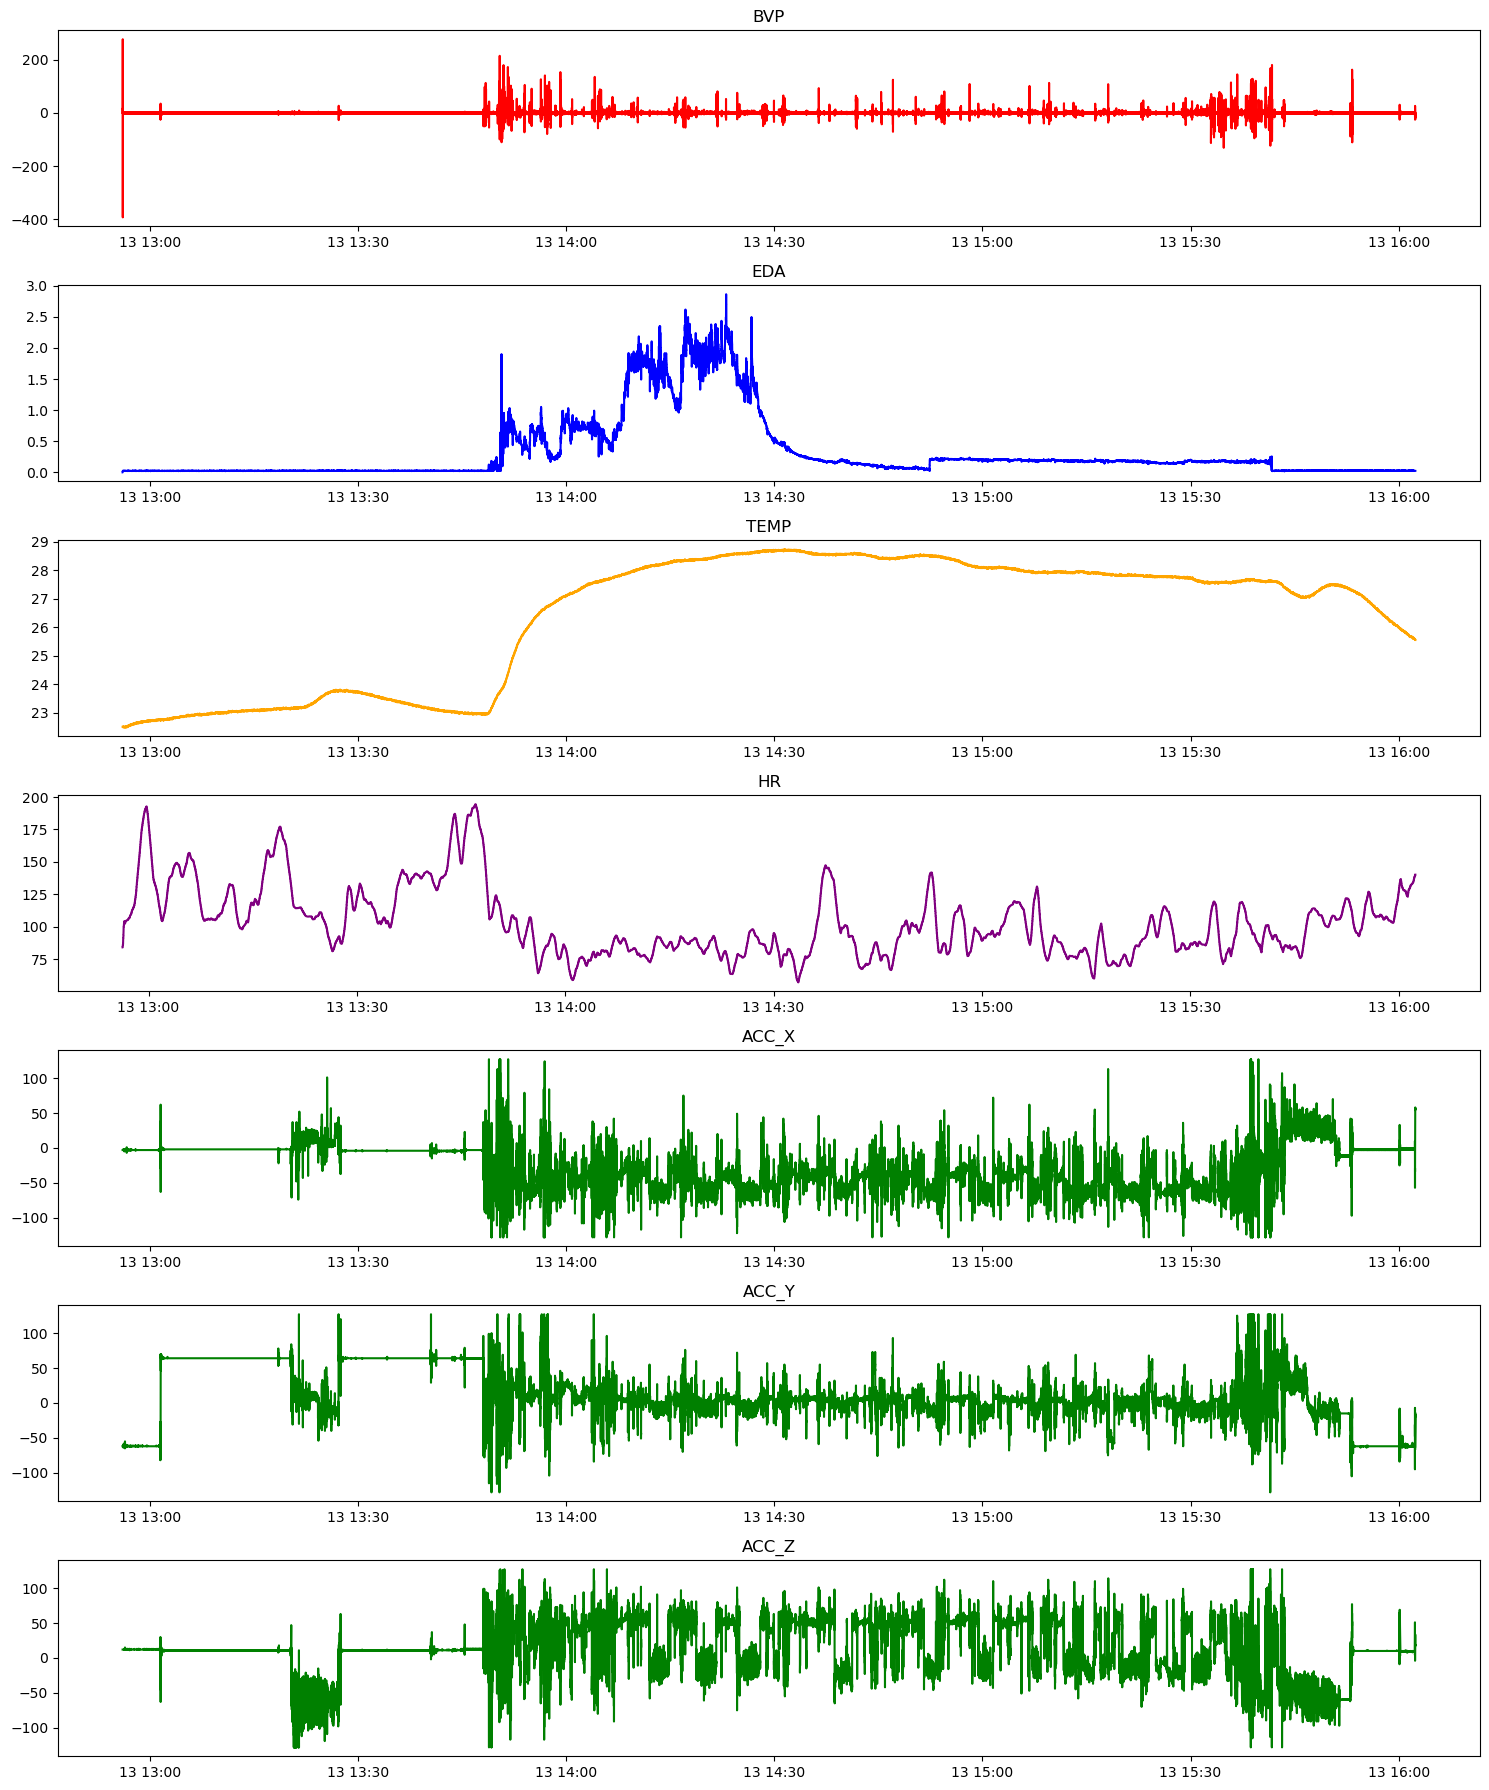

In [25]:
# New visualization for full dataset
def plot_physionet_full(df):
    fig, ax = plt.subplots(7, 1, figsize=(15, 18))
    sensors = [
        ('bvp', 'red'), ('eda', 'blue'), ('temp', 'orange'),
        ('hr', 'purple'), ('acc_x', 'green'), 
        ('acc_y', 'green'), ('acc_z', 'green')
    ]
    for i, (col, color) in enumerate(sensors):
        ax[i].plot(df[col], color=color)
        ax[i].set_title(col.upper())
    plt.tight_layout()
    return fig

plot_physionet_full(physionet_subject)
plt.show()

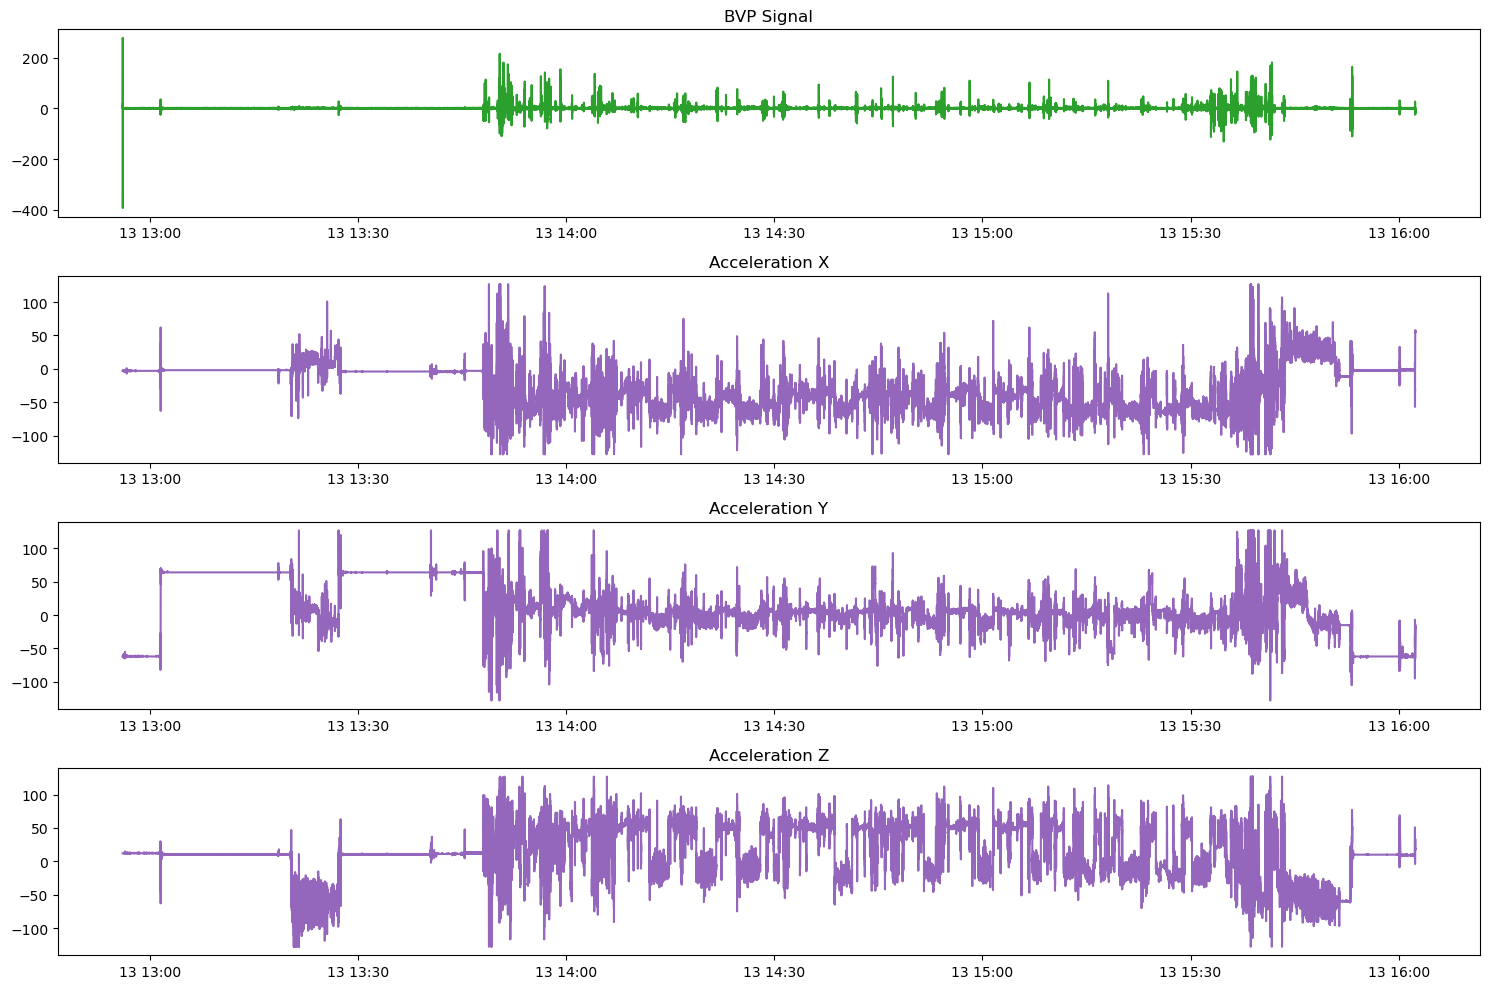

In [26]:
def plot_physionet_signals(df):
    fig, ax = plt.subplots(4, 1, figsize=(15, 10))
    
    # BVP Plot
    ax[0].plot(df['bvp'], color='tab:green')
    ax[0].set_title('BVP Signal')
    
    # ACC Plots
    for i, axis in enumerate(['x', 'y', 'z']):
        ax[i+1].plot(df[f'acc_{axis}'], color='tab:purple')
        ax[i+1].set_title(f'Acceleration {axis.upper()}')
    
    plt.tight_layout()
    return fig

plot_physionet_signals(physionet_subject)
plt.show()

#### Cross-Dataset Comparison

In [27]:
import numpy as np
def compare_signal_stats(*datasets):
    stats = []
    for name, data in datasets:
        acc_cols = ['acc_x','acc_y','acc_z']
        if all(col in data.columns for col in acc_cols):
            acc_mag = np.linalg.norm(data[acc_cols], axis=1).mean()
        else:
            acc_mag = 0.0
            
        stats.append({
            'Dataset': name,
            'BVP Mean': data['bvp'].mean(),
            'BVP Std': data['bvp'].std(),
            'ACC Magnitude': acc_mag
        })
    return pd.DataFrame(stats)

comparison_df = compare_signal_stats(
    ('WESAD', wesad_subject),
    ('PhysioNet', physionet_subject),
)

display(comparison_df.style.background_gradient(cmap='Blues'))

,Dataset,BVP Mean,BVP Std,ACC Magnitude
0,WESAD,-0.052321,0.081453,63.418372
1,PhysioNet,-0.002377,5.795901,64.768402


### Data Quality Report

In [28]:
from ydata_profiling import ProfileReport

def generate_quality_report(df, title, path):
    """Generate automated data quality report with path validation"""
    report_path = Path(path)
    # Create parent directories if missing
    report_path.parent.mkdir(parents=True, exist_ok=True)
    
    profile = ProfileReport(
        df,
        title=title,
        minimal=True,
        correlations=None,  # Speed up generation
        missing_diagrams=None
    )
    profile.to_file(report_path)
    print(f"✅ Report saved to: {report_path.absolute()}")

# Generate reports
generate_quality_report(
    wesad_subject, 
    'WESAD Data Quality',
    '../reports/wesad_quality.html'
)

generate_quality_report(
    physionet_subject,
    'PhysioNet Data Quality',
    '../reports/physionet_quality.html'
)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Report saved to: /Users/uvaishnav/stress_detectin_mm/notebooks/../reports/wesad_quality.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Report saved to: /Users/uvaishnav/stress_detectin_mm/notebooks/../reports/physionet_quality.html


In [29]:
# Test full pipeline
physionet_subject = physionet_loader.load_subject(2, 'Final')
wesad_subject = wesad_loader.load_subject(2)

# Check core requirements
assert {'bvp','acc_x','acc_y','acc_z'}.issubset(physionet_subject.columns)
assert len(physionet_subject) > 700_000
assert physionet_subject['bvp'].isnull().mean() < 0.01

# Generate final reports
generate_quality_report(
    physionet_subject.sample(50_000),  # Use subset for speed
    'PhysioNet Final Quality',
    '../reports/physionet_quality.html'
)

182736 ACC samples exceed 3.5g
Invalid labels detected: {4.0, 6.0, 7.0}


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Report saved to: /Users/uvaishnav/stress_detectin_mm/notebooks/../reports/physionet_quality.html
